# CS696 Assignment 2

## CSV File Paths

In [1]:
VEHICLES_CSV_PATH = './vehicles.csv'
CAUSES_OF_DEATH_CSV_PATH = './causes_of_death.csv'
FRAMINGHAM_CSV_PATH = './framingham.csv'

## Imports, Function Definitions and Variable Declarations

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import sem, t
from scipy import mean

In [3]:
sns.set()          # To set up seaborn's defaults for graph look & feel
DPI = 200          # DPI for all the graphs: increase for higher resolution, decrease for better performance
START_YEAR = 2000  # Range of years to start from
END_YEAR = 2019    # Range of years to end at

def plot_small():
    plt.figure(figsize=(5,3), dpi=DPI)
    
def plot_large():
    plt.figure(figsize=(8,5), dpi=DPI)

def plot_extra_large():
    plt.figure(figsize=(14,8), dpi=DPI)

def plot_extra_large_portrait():
    plt.figure(figsize=(8,14), dpi=DPI)

# TODO add unit test for this
def calculate_ci(data, confidence=0.95, print_results=False):
    '''Calculates the confidence interval of the given array-like data.
    '''
    num_samples = len(data)
    mean_value = mean(data)
    std_err = sem(data)
    deviation = std_err * t.ppf((1 + confidence) / 2, num_samples - 1)

    start = mean_value - deviation
    end = mean_value + deviation
    if print_results:
        print("{}% Confidence Interval: {} - {}".format(confidence*100, start, end))
    return [start, mean_value, end]

## Issue 1 - Auto Fuel Economy
We'll create some variables and dataframes that we'll use for the questions in issue 1.

Hybrid vehicles and Plug-in hybrid vehicles are both included. As per the documentation provided for the dataset, the comb08 column notes the MPG for fuelType1, which is gasoline in our analysis. This means we can compare both kinds of hybrid vehicles directly to gasoline vehicles as the value involves much gasoline was used.

#### Note on revised estimates
On the EPA website from where we get the data, there are revisions posted for the MPG values of various models.
In our case, Ford vehicles from 2013 - 2014 were affected.
However, the EPA has updated these revisions into the combined dataset for all model years from 1984 to 2020 which has been used as the data source for this notebook.

On top of that, the EPA revised how it measures MPG in 2008 and in 2017. These revisions affected the MPG estimates of some cars, which has also been incorporated by the EPA into the dataset. So by using the combined dataset provided by the EPA we have all the latest MPG values, in a converted format that allows us to directly compare all the vehicles across decades, with no preprocessing necessary.

In [4]:
auto_cols_to_read = ['year', 'make', 'comb08', 'fuelType1', 'fuelType2']
auto_df = pd.read_csv(VEHICLES_CSV_PATH, usecols=auto_cols_to_read)
brand_subsidiaries = {
    'General Motors': ['General Motors', 'Chevrolot', 'Cadillac', 'GMC'],
    'Ford': ['Ford', 'Lincoln'],
    'Chrysler': ['Chrysler', 'Dodge', 'Jeep', 'Ram'],
    'Toyota': ['Toyota', 'Daihatsu', 'Lexus', 'Subaru'],
    'Honda': ['Honda', 'Acura'],
}
brands = list(brand_subsidiaries.keys())
fuel_types = ['Midgrade Gasoline', 'Regular Gasoline', 'Premium Gasoline']

#### Filtering the data
We're only interested in cars which satisfy some criteria:
* Manufactured between given years
* Belong to certain companies
* Use gasoline as their primary fuel

So we'll filter out the dataframe based on these constraints.

In [5]:
auto_df = auto_df.loc[auto_df.year.isin(range(START_YEAR, END_YEAR+1)) & auto_df.fuelType1.isin(fuel_types)]
company_dfs = []
for brand in brands:
    temp_df = auto_df[auto_df['make'].isin(brand_subsidiaries[brand])]
    company_dfs.append(temp_df.replace(brand_subsidiaries[brand], brand))
auto_df = pd.concat(company_dfs)

### Question 1: Box plots for combined MPG for all cars sold by each brand

#### MPG per year for each company

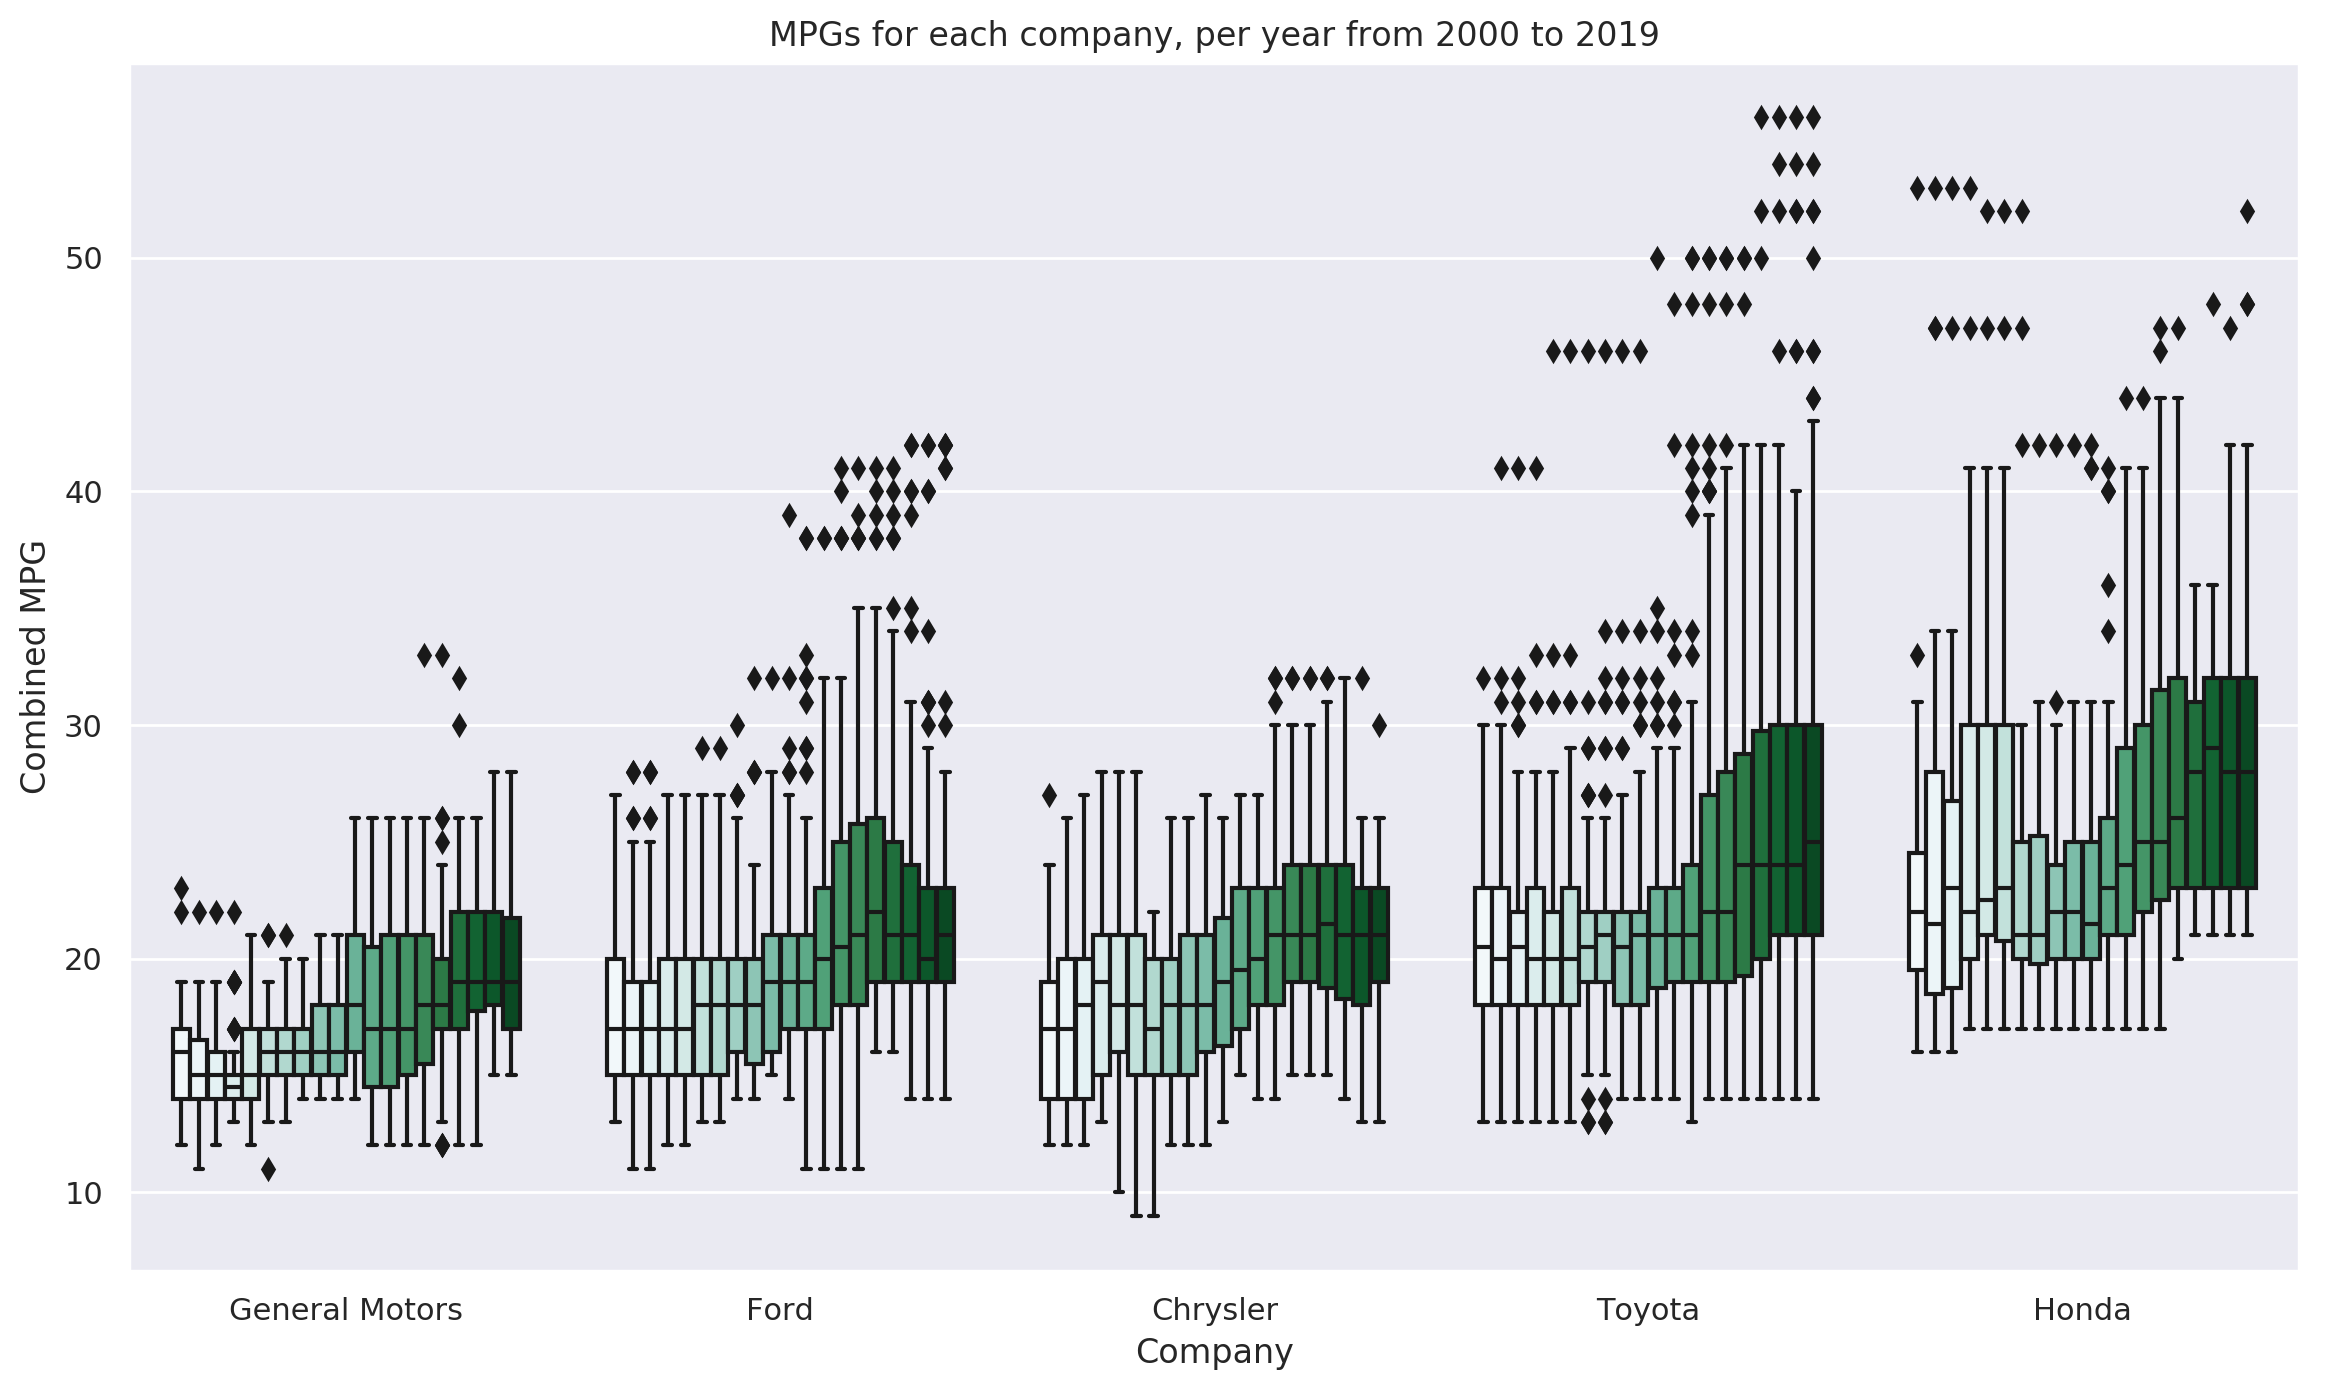

In [6]:
plot_extra_large()
ax = sns.boxplot(x='make', y='comb08', hue='year', data=auto_df, palette="BuGn")
ax.legend_.remove()
plt.xlabel('Company')
plt.ylabel('Combined MPG')
plt.title('MPGs for each company, per year from {} to {}'.format(START_YEAR, END_YEAR));

#### MPG per company for each year

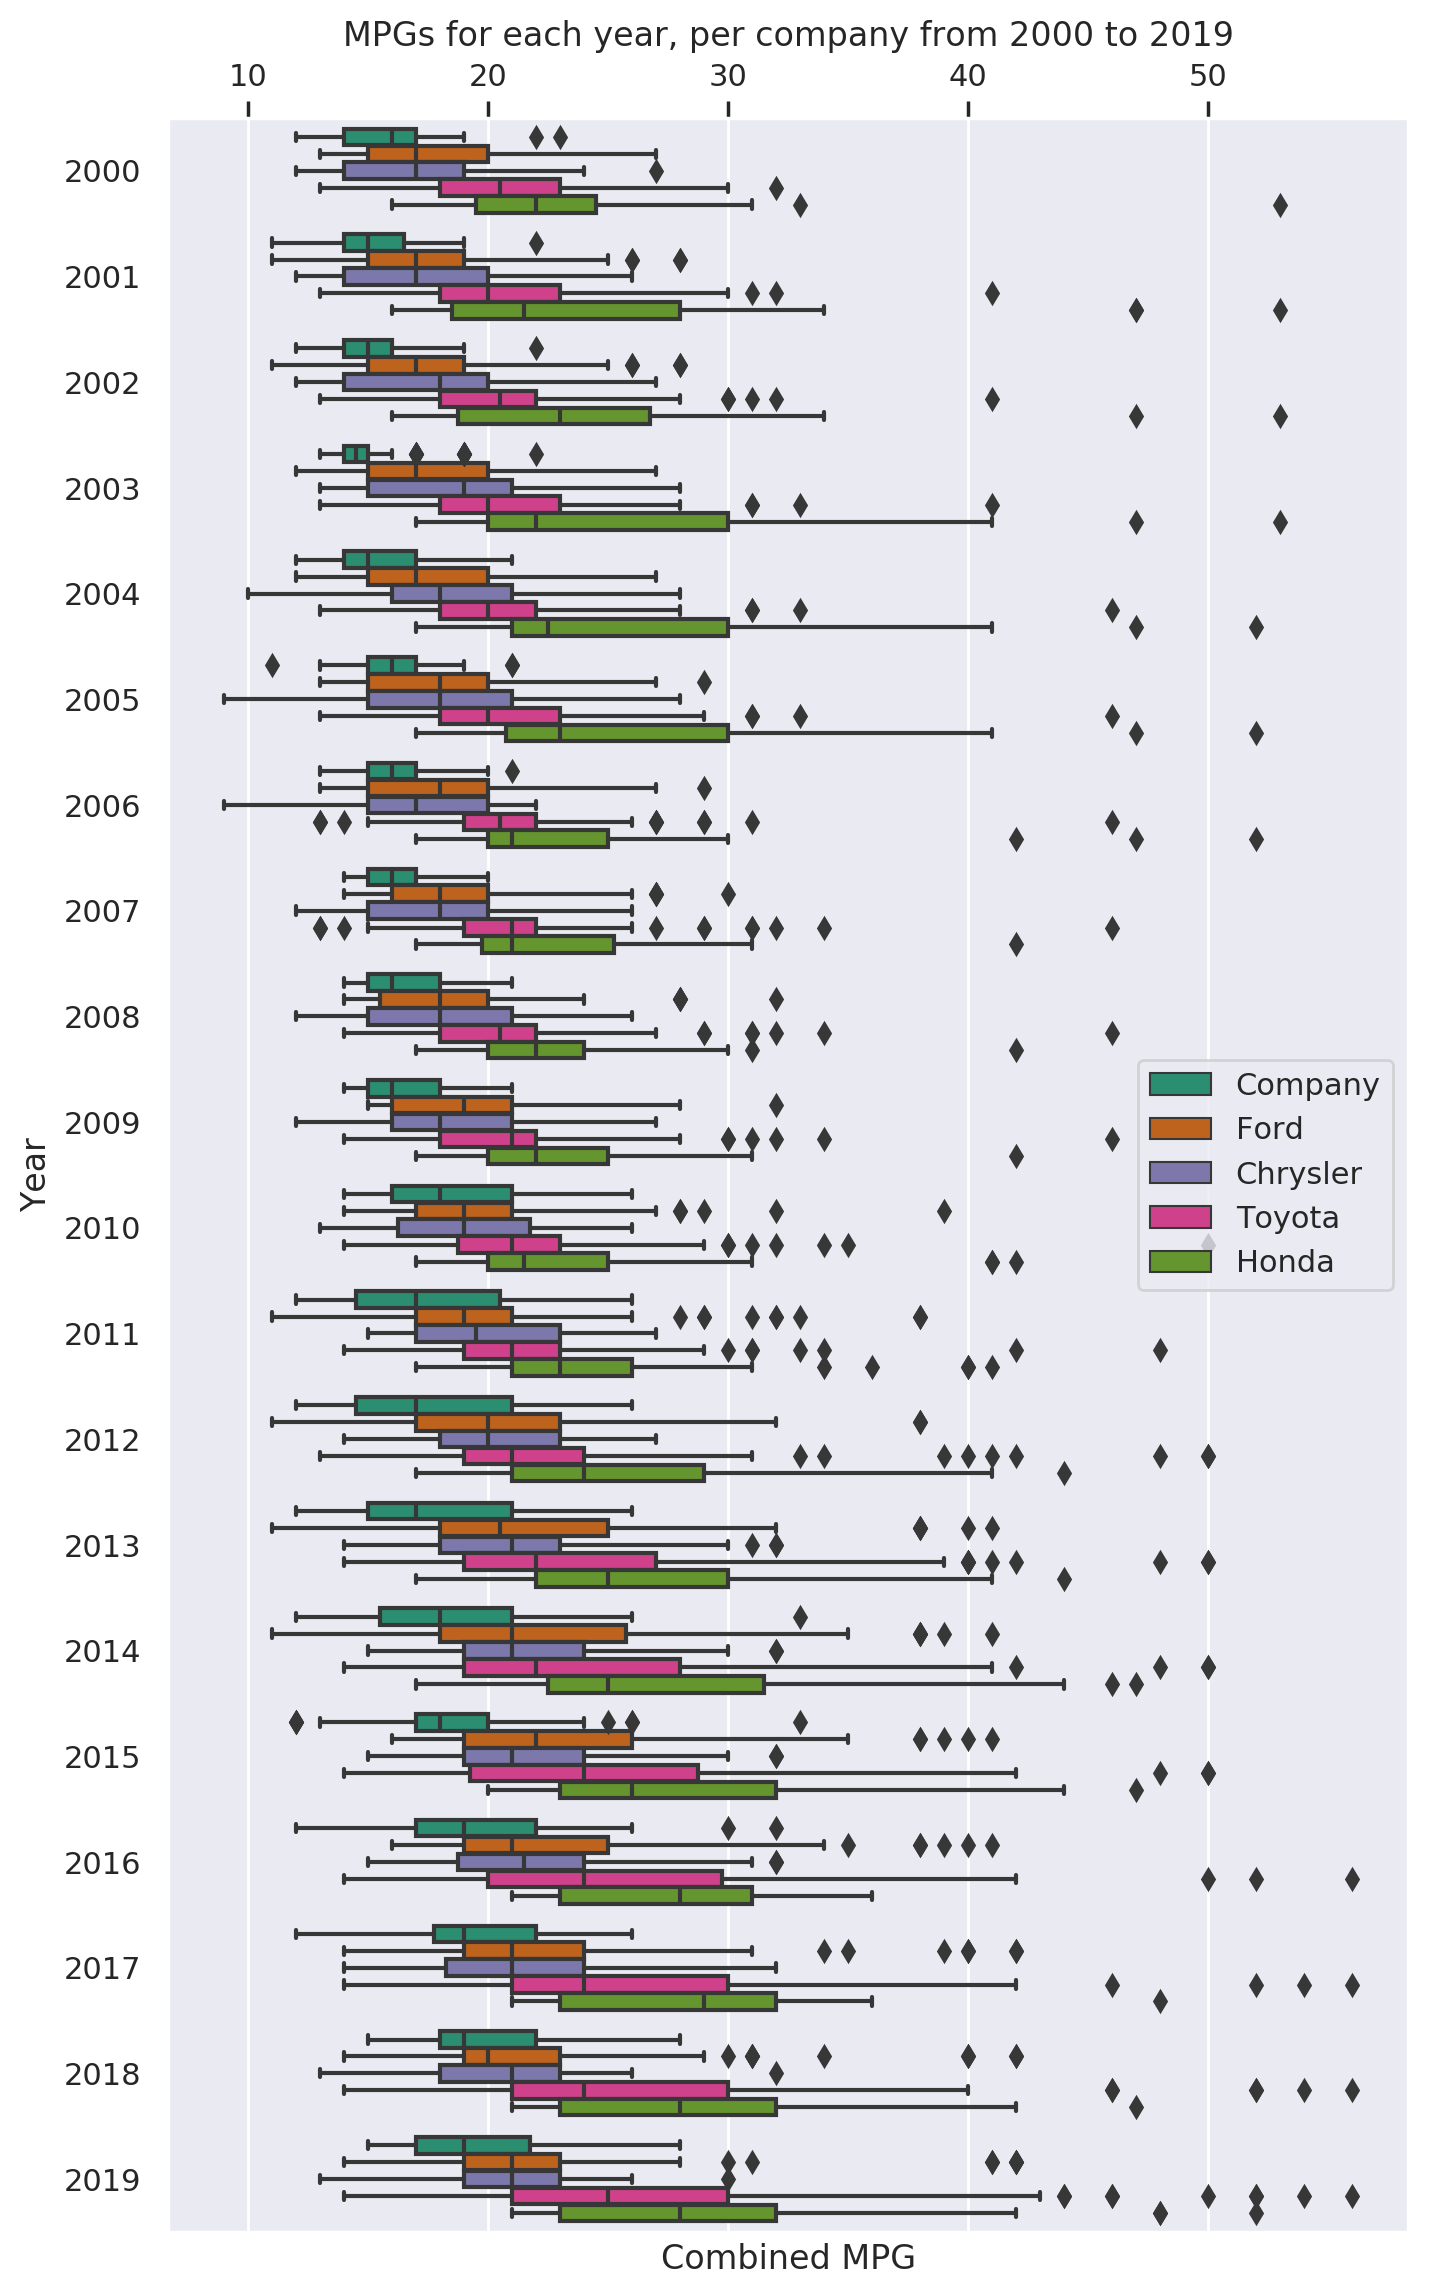

In [7]:
plot_extra_large_portrait()
ax = sns.boxplot(x='comb08', y='year', hue='make', data=auto_df, orient='h', palette="Dark2")
ax.xaxis.tick_top()
ax.legend().texts[0].set_text('Company')
plt.xlabel('Combined MPG')
plt.ylabel('Year')
plt.title('MPGs for each year, per company from {} to {}'.format(START_YEAR, END_YEAR));

#### Comparison between companies
* From the above plots, we can see that the 2 Japanese companies - Honda and Toyota - have consistently better MPG across the years than the 3 American companies.
* Honda, Toyota, and Ford have a lot more outliers and larger inter-quartile ranges than the other 2 companies due to the presence of hybrid vehicles in their lineups.
* All companies have consistently improved their MPG over the years though.

### Question 2: Average combined MPG for all cars sold by each brand

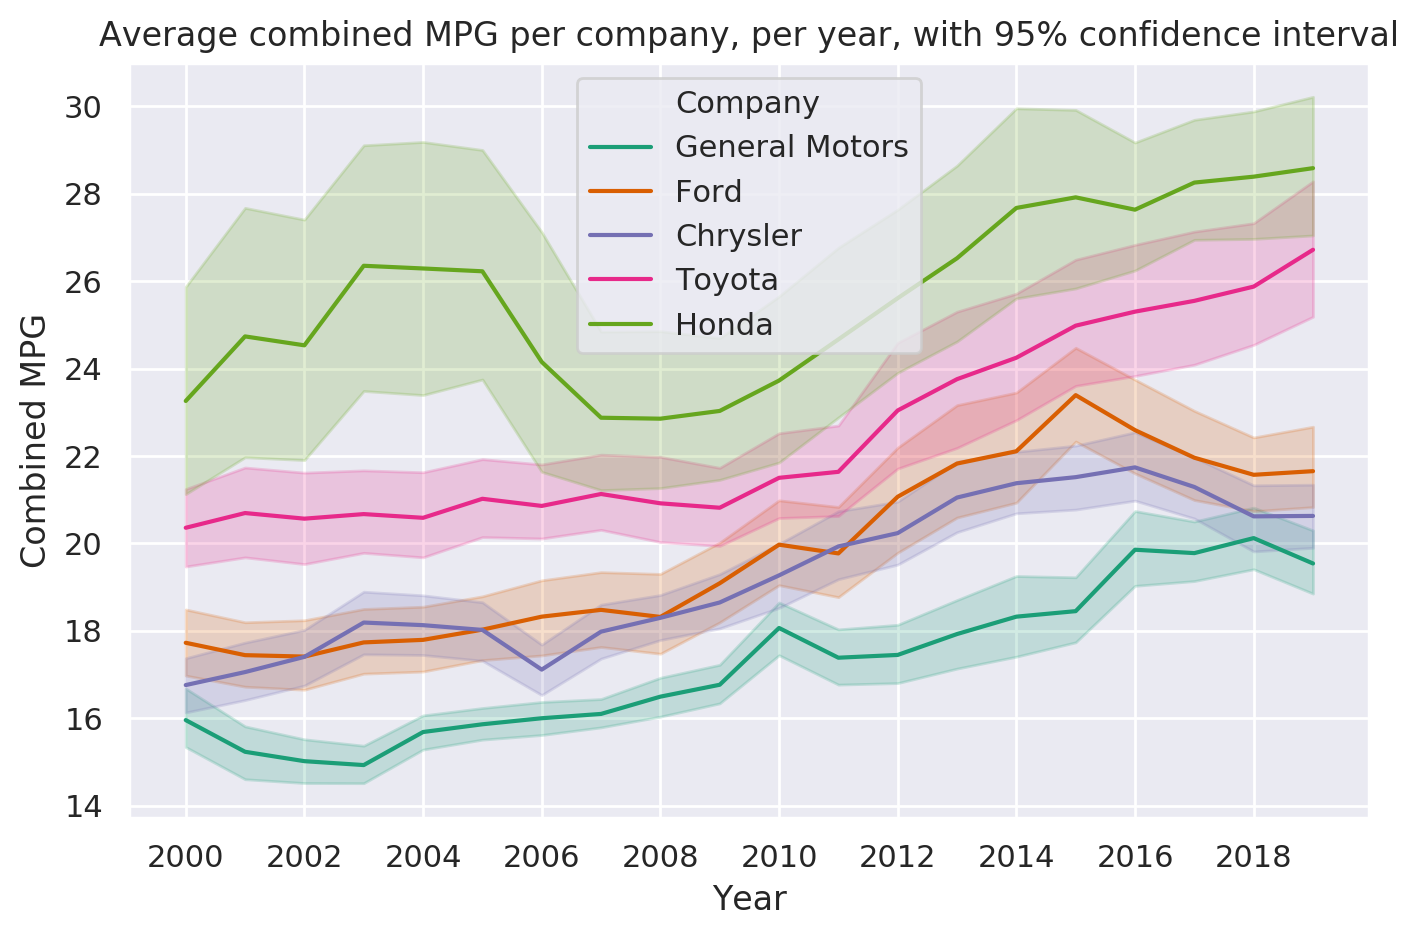

In [8]:
plot_large()
ax = sns.lineplot(x='year', y='comb08', hue='make', data=auto_df, palette="Dark2")
plt.xticks(range(START_YEAR, END_YEAR, 2))
ax.legend().texts[0].set_text('Company')
plt.xlabel('Year')
plt.ylabel('Combined MPG')
plt.title('Average combined MPG per company, per year, with 95% confidence interval');

### Question 3: Max combined MPG for each brand per year (2000 - 2019)

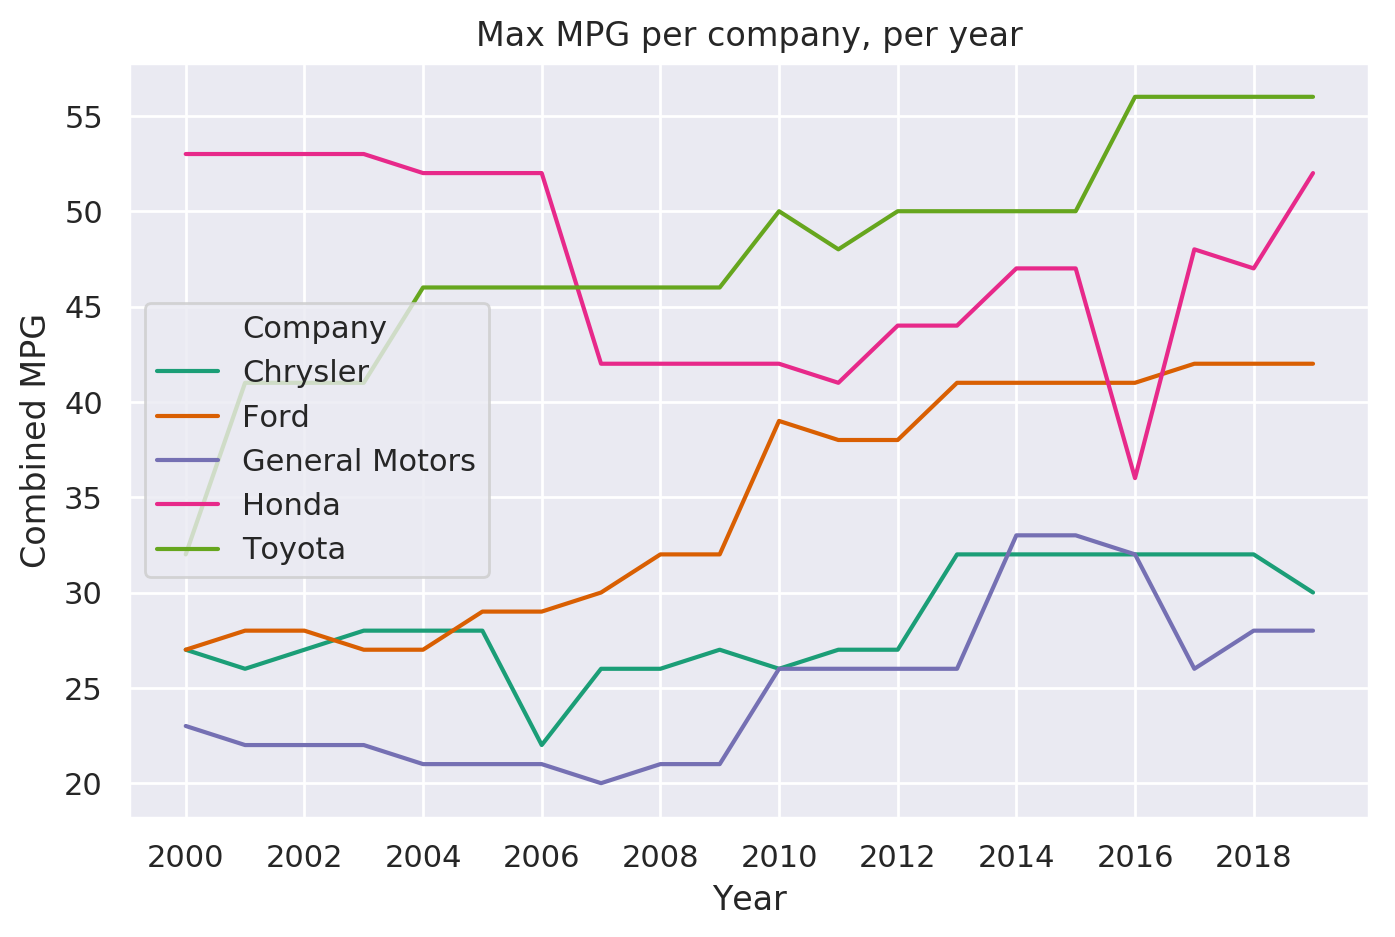

In [9]:
prob1c_df = auto_df.groupby(['make', 'year'])['comb08'].max().reset_index()
plot_large()
ax = sns.lineplot(x='year', y='comb08', hue='make', data=prob1c_df, palette="Dark2")
plt.xticks(range(START_YEAR, END_YEAR+1, 2))
plt.xlabel('Year')
plt.ylabel('Combined MPG')
ax.legend().texts[0].set_text('Company')
plt.title('Max MPG per company, per year');

## Issue 2 - Diet and Death
Once again we'll read in CSV files and create some dataframes for problems in issue 2.

In [10]:
cod_df = pd.read_csv(CAUSES_OF_DEATH_CSV_PATH)
framingham_df = pd.read_csv(FRAMINGHAM_CSV_PATH)

#### Plot of death rate for each disease over the years

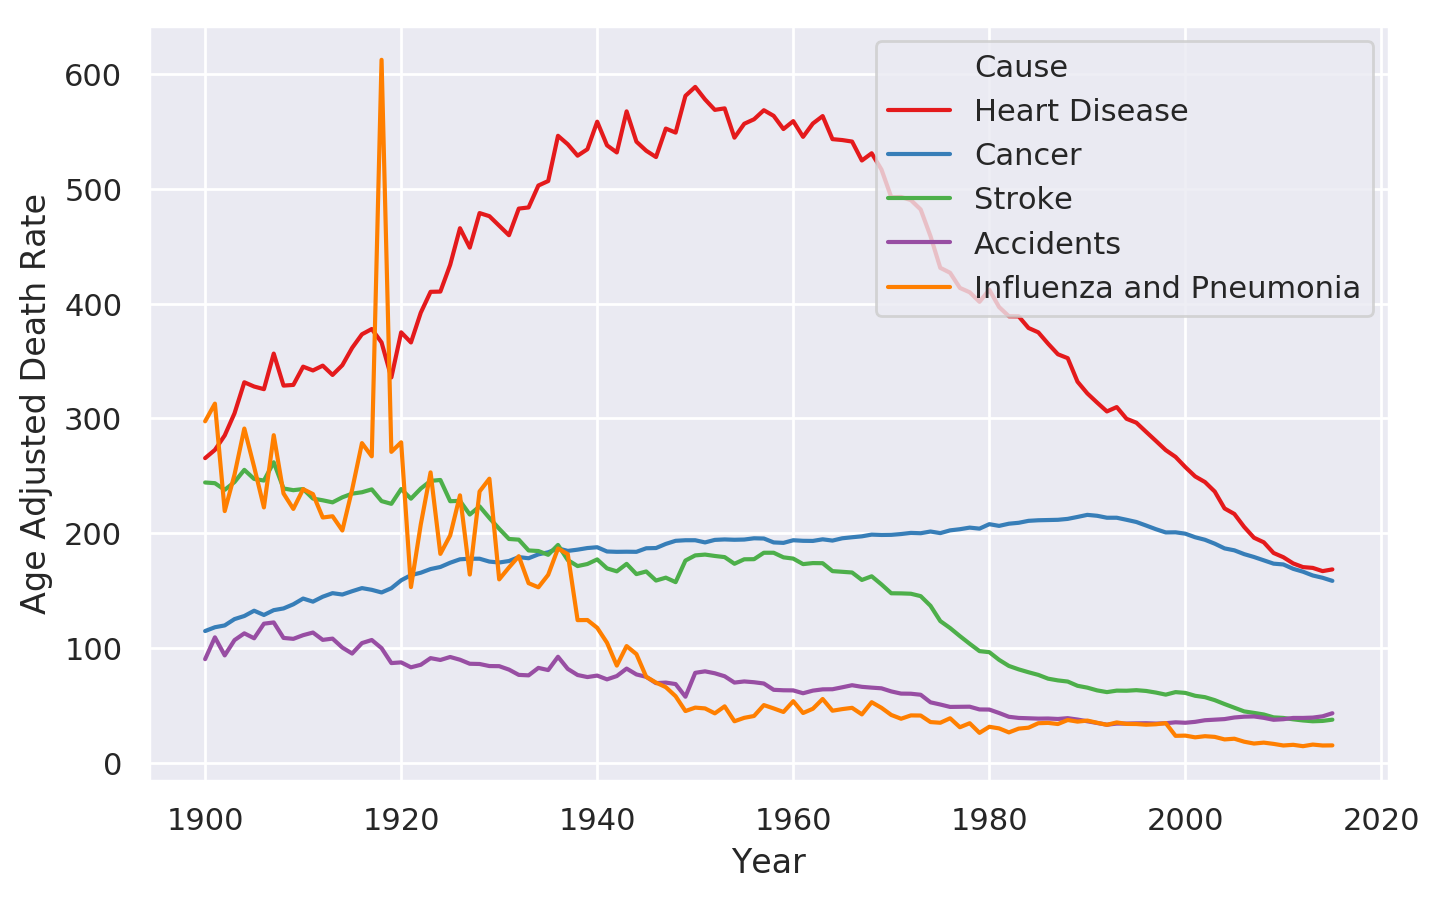

In [11]:
plot_large()
sns.lineplot(x="Year", y="Age Adjusted Death Rate", hue="Cause", data=cod_df, palette="Set1");

### Question 4: Percentage of people with Diabetes, as per Framingham

In [12]:
percentages = framingham_df['DIABETES'].value_counts(normalize=True) * 100
framingham_diabetes_percentage = percentages[1]
print("Percentage: {}%".format(framingham_diabetes_percentage))

Percentage: 2.732951587714732%


### Question 5: Histogram of random samples

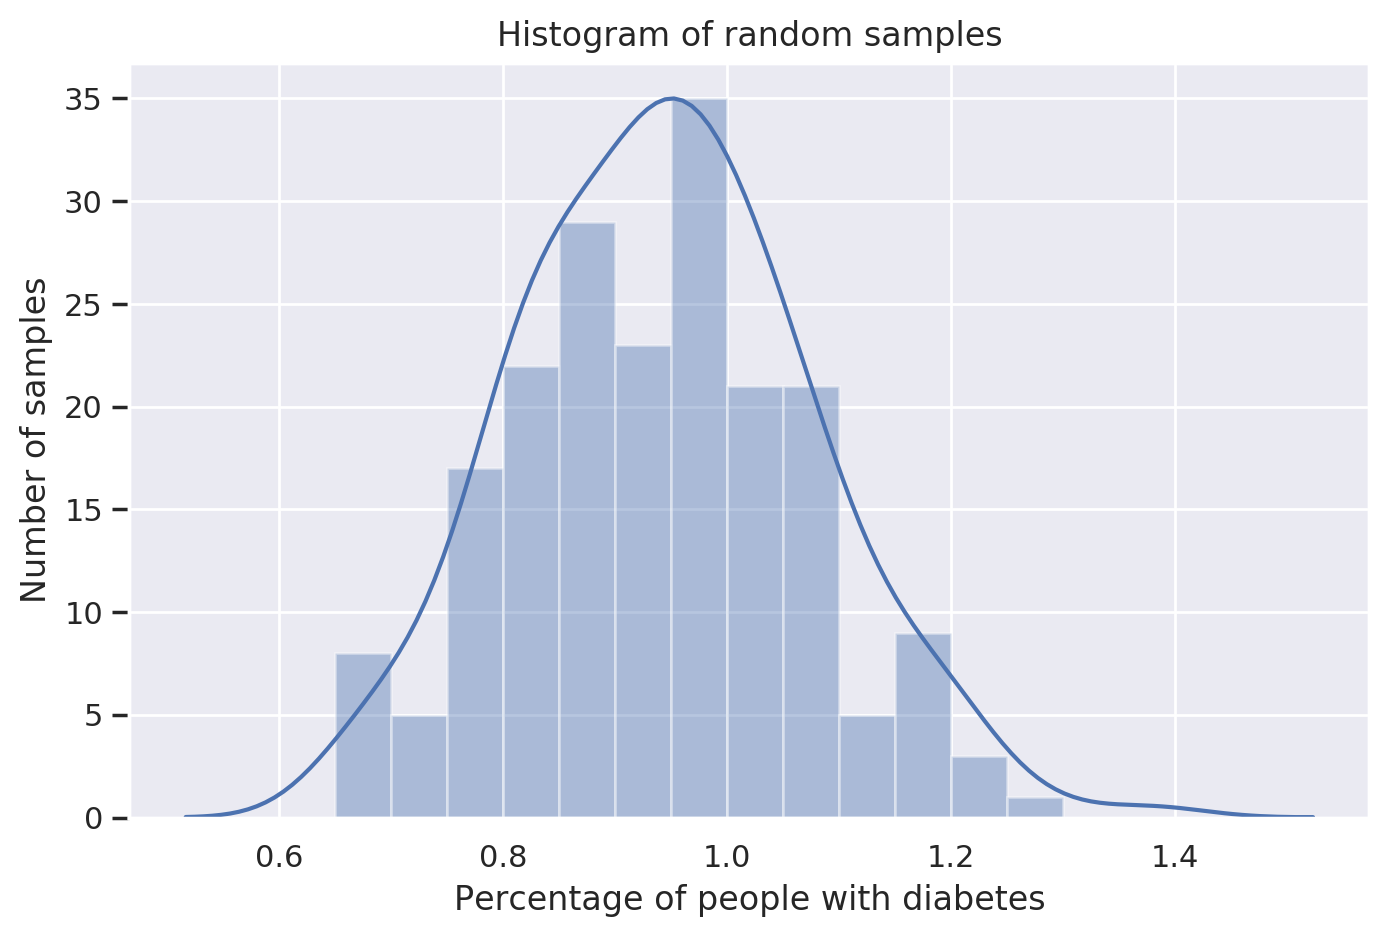

In [13]:
# Variables
random_samples = []
sample_size = 5000
cdc_diabetes_prevalance = 0.0093
num_samples = 200
probabilities = [1 - cdc_diabetes_prevalance, cdc_diabetes_prevalance]

# Generating random samples
for i in range(num_samples):
    random_samples.append(np.random.multinomial(sample_size, probabilities))
random_samples_df = pd.DataFrame(random_samples)
percentages = random_samples_df[1] * 100 / sample_size

# Calculate the range for the bins
min_dist_value = min(percentages)
max_dist_value = max(percentages)

# Variables to fine tune the histogram's bins
tick_range = 0.1
bins_per_tick = 2
tick_step = tick_range / bins_per_tick

# Calculate the ranges of the bins, and add some buffer
range_start = int(min_dist_value/tick_range) * tick_range
range_end = (int(max_dist_value/tick_range) * tick_range) + tick_range

# Plotting histogram with some fun matplotlib hacks to show the
# Gaussian distribution estimation with counts instead of density on the y axis
plot_large()
ax = sns.distplot(percentages, kde=False, bins=scipy.arange(range_start, range_end, tick_step))

plt.title('Histogram of random samples')
plt.xlabel('Percentage of people with diabetes')
plt.ylabel('Number of samples');

second_ax = ax.twinx()
sns.distplot(percentages, hist=False, ax=second_ax, bins=scipy.arange(range_start, range_end, tick_step))
second_ax.set_yticks([]);

### Question 6: 95% Confidence Interval for samples computed in Question 5

In [14]:
calculate_ci(random_samples_df[1], print_results=True);

95.0% Confidence Interval: 46.31437466252644 - 48.12562533747356


### Question 7: Is the study representative of the general population?

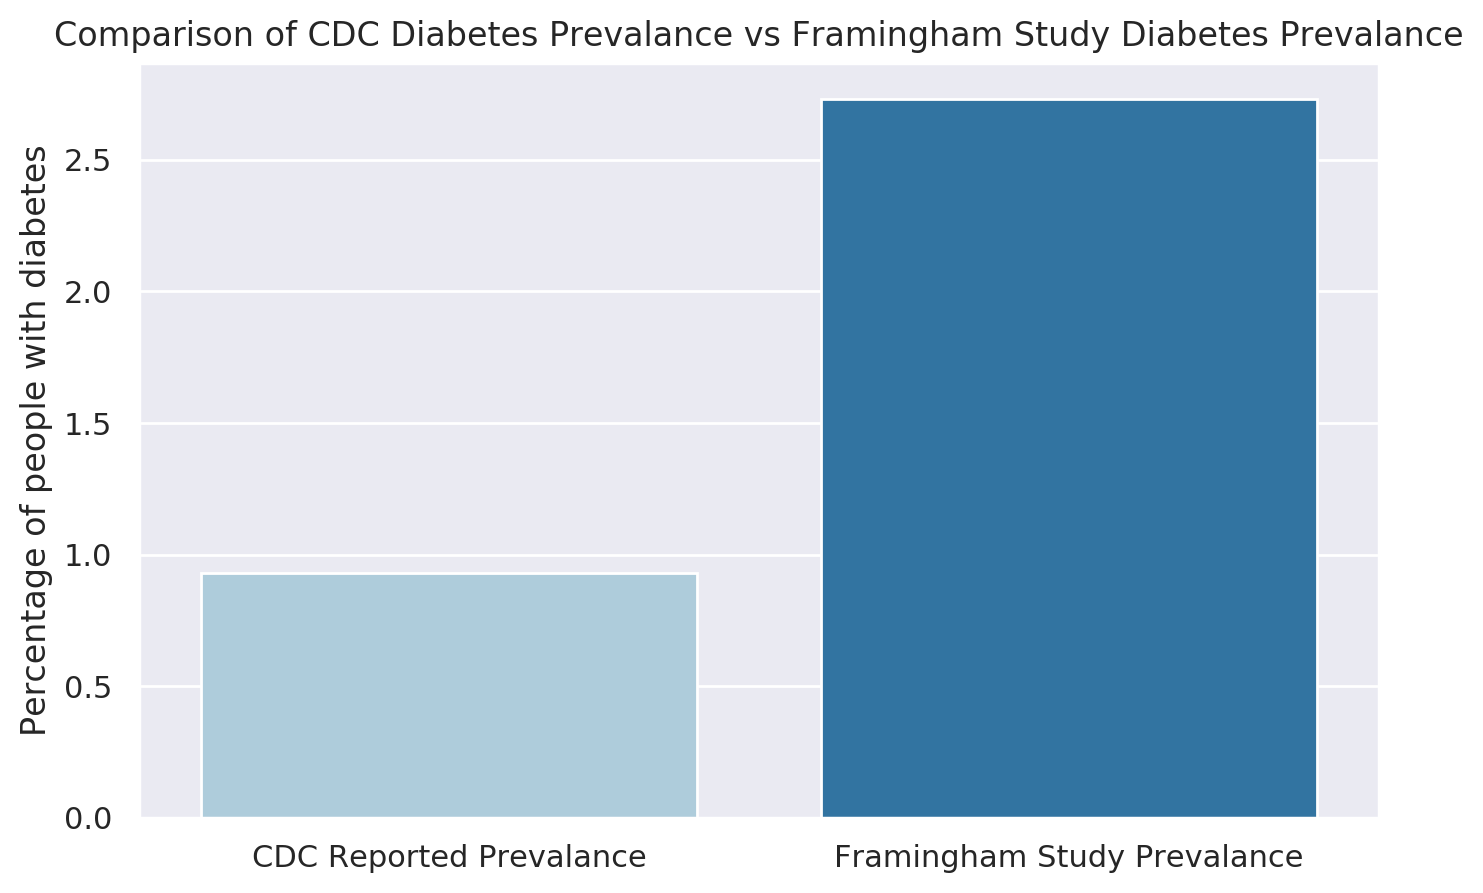

In [15]:
# TODO use the calculations
plot_large()
sns.barplot(x=['CDC Reported Prevalance', 'Framingham Study Prevalance'],
            y=[cdc_diabetes_prevalance * 100, framingham_diabetes_percentage], palette="Paired")
plt.title("Comparison of CDC Diabetes Prevalance vs Framingham Study Diabetes Prevalance")
plt.ylabel("Percentage of people with diabetes");

The CDC stated that the prevelance of diabetes at the time of the study was 0.93%. However, from the above calculations (specifically from Question 4) we can see that the percentage of people with diabetes in the study is **2.73%**.

Clearly the proportion of diabetic people in the study is more than the proportion of diabetic people in the general population by quite a large margin (nearly 2.7 times more diabetics in the study than in the general population). For that reason the study may not be representative of the general population.The CDC stated that the prevelance of diabetes at the time of the study was 0.93%. However, from the above calculations (specifically from Question 4) we can see that the percentage of people with diabetes in the study is **2.73%**.

Clearly the proportion of diabetic people in the study is more than the proportion of diabetic people in the general population by quite a large margin (nearly 2.7 times more diabetics in the study than in the general population). For that reason the study may not be representative of the general population.

### Question 8: Plot of cholesterol values of people in Framingham Study with heart disease vs. people without

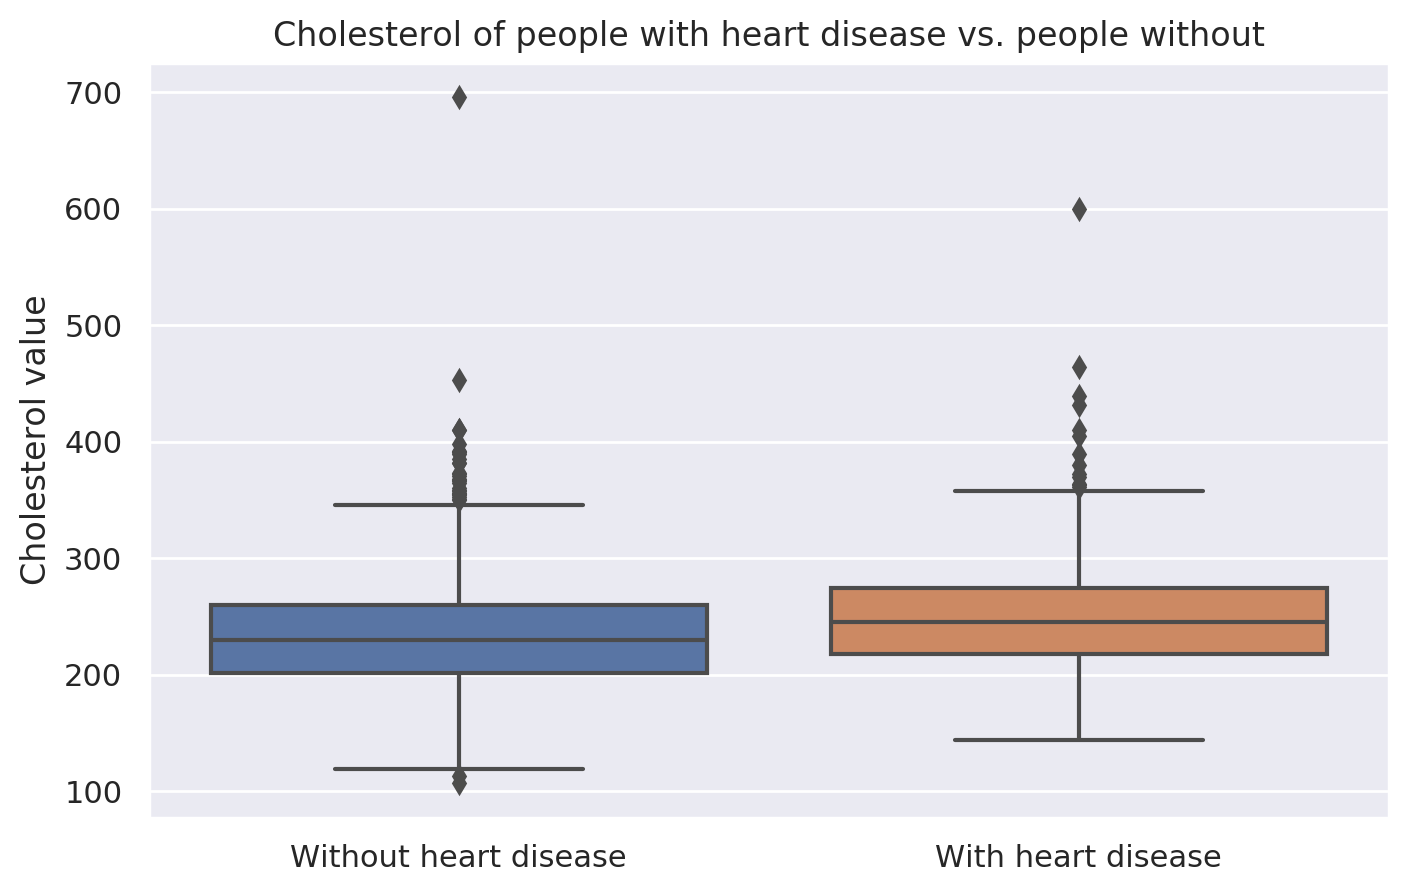

In [16]:
plot_large()
sns.boxplot(x='ANYCHD', y='TOTCHOL', data=framingham_df)
plt.title('Cholesterol of people with heart disease vs. people without')
plt.xticks(range(2), ['Without heart disease', 'With heart disease'])
plt.xlabel('')
plt.ylabel('Cholesterol value');

### Question 9: 95% Confidence Interval of cholesterol for people in Framingham Study with heart disease vs. people without

In [17]:
print("Cholesterol CI for people with heart disease:")
ci_with_heart_disease = calculate_ci(framingham_df.query('ANYCHD == 1')['TOTCHOL'].values, print_results=True)
print("Cholesterol CI for people without heart disease:")
ci_without_heart_disease = calculate_ci(framingham_df.query('ANYCHD == 0')['TOTCHOL'].values, print_results=True)

Cholesterol CI for people with heart disease:
95.0% Confidence Interval: 246.5403082552965 - 252.42405233170558
Cholesterol CI for people without heart disease:
95.0% Confidence Interval: 231.25983474347473 - 234.43268603214855


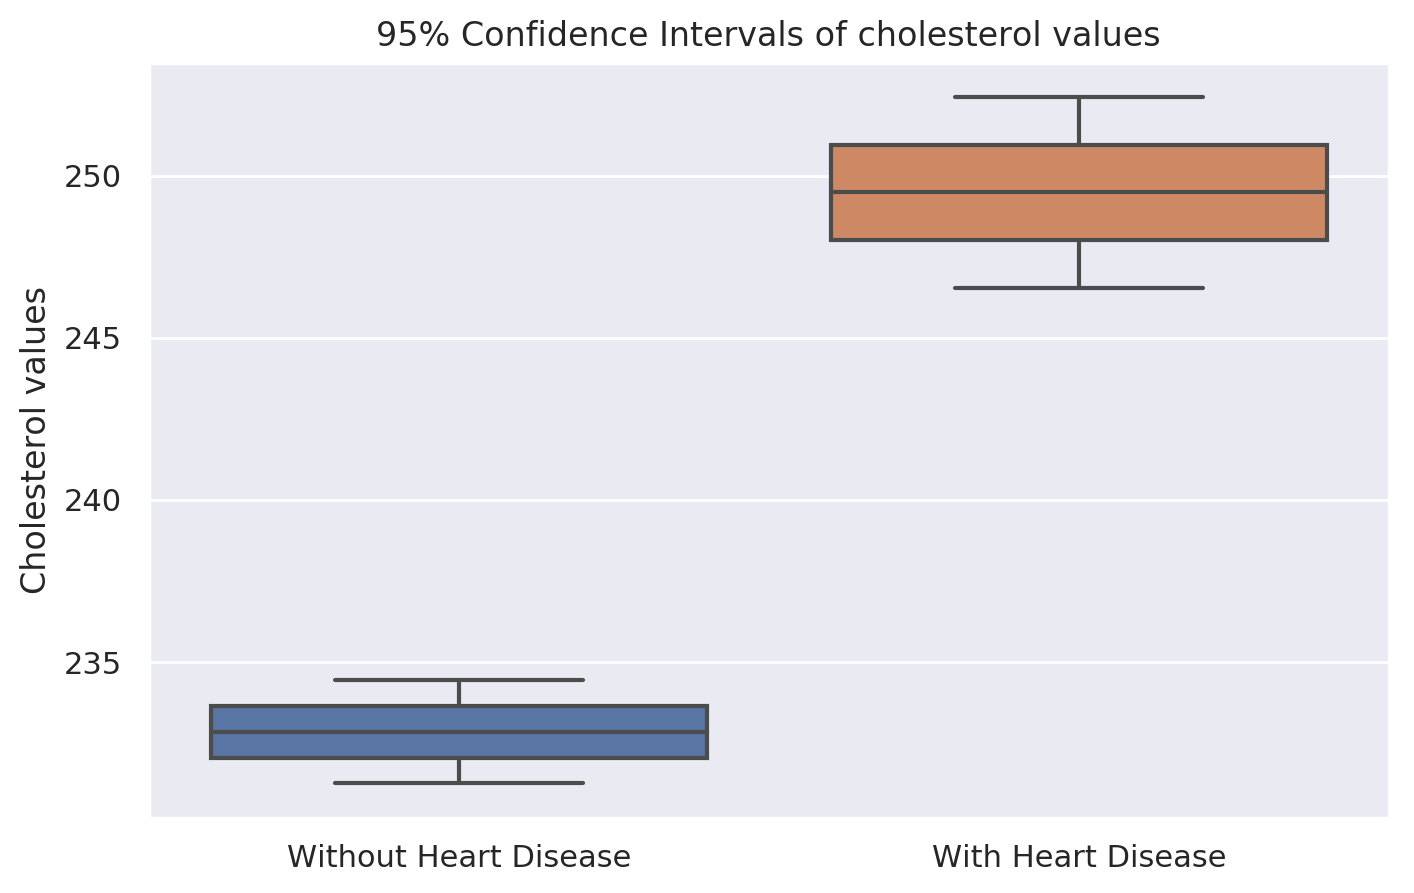

In [18]:
plot_large()
ci_df = pd.DataFrame(index=['Without Heart Disease', 'With Heart Disease'],
                     columns=['Lower Range', 'Mean', 'Upper Range'],
                     data=[list(ci_without_heart_disease), list(ci_with_heart_disease)]).T
sns.boxplot(data=ci_df)
plt.title('95% Confidence Intervals of cholesterol values');
plt.ylabel('Cholesterol values');

### Question 10: Comments on the correlation between cholesterol values and heart disease
Looking at the plot from question 8 and the results of question 9, one can say that people with heart disease are likelier to have higher cholesterol values than people without heart disease.